<h1>Projet </h1>

In [1]:
import pymongo
import pandas
import seaborn
from pprint import pprint

con = pymongo.MongoClient("mongodb://193.51.82.104:2343/") #connexion

horo = con.horodateurs

In [2]:
trans= horo.transactions_small
mob= horo.mobiliers

In [3]:
import folium
import json

geo = json.load(open("paris-arrondissements.geojson"))

centre = [48.86, 2.35]

# Regard général sur les données

In [85]:
pandas.DataFrame(list(trans.aggregate([
    { "$group": { 
        "_id": "dates limites", 
        "debut": { "$min": "$date horodateur" },
        "fin": { "$max": "$date horodateur" } 
    }}
])))

,_id,debut,fin
0,dates limites,2014-01-01 01:25:19,2014-12-31 20:37:59


Les données des transactions concernent l'année 2014. On va regarder l'utilisation générale des horodateurs:

### Durée de stationnement en fonction de l'heure d'arrivée

On créé la variable heure 

In [108]:
res= trans.aggregate([
    {"$project": {"heure": {"$hour": "$début stationnement"}}}
])
df= pandas.DataFrame(list(res))

In [109]:
res= trans.aggregate([
    {"$project": {"durée": "$durée payée (h)"}}
])
df2= pandas.DataFrame(list(res))

In [110]:
df['Duree']= df2.durée

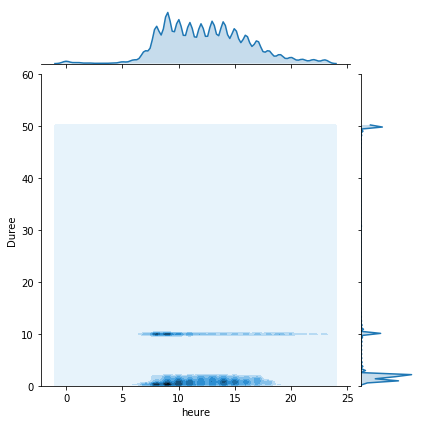

In [111]:
seaborn.jointplot(x = "heure", y = "Duree", data = df, kind = "kde", ylim=(0,60))

On voit que trois tendances de durée se dégagent: 
1. Les durées d'environ 1h ou 2h
2. Les durées d'environ 10h
3. les durées d'environ 50h

De plus, les petites durées n'ont pas lieu après 20h. Enfin, l'heure qui comptabilise le plus d'arrivées est aux alentours de 9h du matin.

### Evolution montant total par jour, au cours de l'année

In [112]:
res= trans.aggregate([
    {"$project": {"jour": {"$dayOfYear": "$date horodateur"}}},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    {"$unwind": "$trans"},
    {"$group": {"_id": "$jour", "montant": {"$sum": "$trans.montant carte"}}} 
])
df3= pandas.DataFrame(list(res))
df3.columns = ['Jour', 'MontantTotal']
df3.head()

,Jour,MontantTotal
0,215,0.6
1,227,13.2
2,229,13.8
3,236,14.7
4,222,4.8


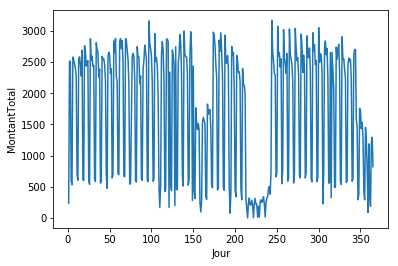

In [113]:
seaborn.lineplot(x = "Jour", y = "MontantTotal", data = df3)

La courbe du montant total des transactions par jour est périodique. Les pics les plus bas correspondent aux week-ends. On discerne également trois périodes où le montant (le plus élevé) est plus bas que d'habitude:
1. D'abord, entre le 150ème jour et le 160ème jour. Ce qui peut correspondre aux ponts de mai.
2. Ensuite, entre le 210ème jour et le 240ème jour. Ces jours tombent pendant les mois de juillet-août.
3. Enfin, à partir du 340ème jour, c'est à dire, pendant les fêtes de fin d'années.

Il est raisonnable de penser que la plupart des paiements proviennent de parisiens (et moins de touristes par exemple).

### Tarif moyen d'un horodateur selon l'arrondissement

In [4]:
mob.distinct('fields.tarifhor')

[4.0, 2.4]

On constate qu'il n'y a que deux tarifs possibles: 4€ par heure ou bien 2,4€ par heure.

In [114]:
res = mob.aggregate([
    { "$group": { "_id": "$fields.arrondt", "nb": { "$avg": "$fields.tarifhor" }} },
    { "$sort": {"_id": 1}}
])
df4 = pandas.DataFrame(list(res)) 
df4.columns = ["Arrondissement", "TarifMoyen"]

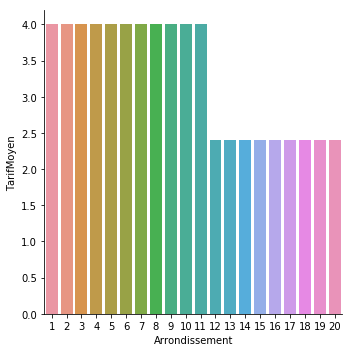

In [115]:
seaborn.catplot(x = "Arrondissement", y = "TarifMoyen", data = df4, kind="bar")

Tous les horodateurs présents dans le centre de Paris (du 1er au 11ème arrondissement) ont un tarif horaire de 4€. 

#### Remarque sur le nombre d'horodateurs

Nombre d'horodateurs dans mobiliers: 

In [20]:
a=mob.distinct('fields.numhoro')
len(a)

7810

Nombre d'horodateurs dans transactions_small:

In [19]:
b=trans.distinct('horodateur')
len(b)

7892

On remarque que les paiements concernent également des horodateurs qui ne sont pas dans la ville de Paris, ou en tout cas qui ne sont pas répértoriés dans la liste des horodateurs de la ville de Paris.

### Nombre d'horrodateur par superficie(ha) par arrondissement

Nombre d'horodateurs par arrondissement:

In [116]:
res= mob.aggregate([
    {"$group" : {"_id": "$fields.arrondt", "nb": {"$sum": 1}}},
    {"$sort": {"_id":1}}
])
df6 = pandas.DataFrame(list(res)) 
df6.columns = ["Arr", "Nb"]
df6.head()

,Arr,Nb
0,1,87
1,2,67
2,3,133
3,4,135
4,5,267


En s'appuyant sur des recherches, on créé la liste des superficies par arrondissement (dans l'ordre des arrondissements)

In [86]:
superficie= [183,99,117,160,254,215,409,388,218,289,367,1632,715,564,848,1637,567,601,679,598]

In [117]:
df6['Superficie']=superficie

In [118]:
df6['NbSup']= df6.Nb/df6.Superficie
df6.head()

,Arr,Nb,Superficie,NbSup
0,1,87,183,0.475410
1,2,67,99,0.676768
2,3,133,117,1.136752
3,4,135,160,0.843750
4,5,267,254,1.051181


In [119]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df6, columns = ["Arr", "NbSup"],
                 fill_color= "YlGn",
                 legend_name = "Nombre d horrodateurs par superficie").add_to(carte)
carte

A partir de cette carte, on constate que les arrondissements qui ont le plus d'horodateurs par rapport à leur taille sont: le 3ème, le 11ème et le 17ème. Au contraire, l'arrondissement qui a le moins d'horodateurs par rapport à sa superficie est le 12ème.

On se propose dans la suite, d'étudier la capacité des données des horodateurs à décrire les fonctions des arrondissements. Par exemple, on s'attend à voir de petits temps de stationnements dans le centre de Paris, ces stationnements étant plutôt motivés par des loisirs (shopping...). On va également chercher si certains arrondissements accueillent plus de stationnements que d'autres à des heures tardives, signe que les arrondissements en question ont une activité nocturne développée (bars, théâtres, restaurants...).

# Fréquence et durée d'utilisation des horodateurs par arrondissement

### Durée moyenne d'un stationnement par arrondissement

In [32]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}}, #pour s'assurer qu'on connait l'arrondissement
    { "$lookup": {
        "from": "mobiliers",
        "localField": "horodateur",
        "foreignField": "fields.numhoro",
        "as": "mobilier"
    }},
    { "$unwind": "$mobilier"},
    { "$group":{"_id": "$mobilier.fields.arrondt", "nb":{"$avg": "$durée payée (h)"}}}
])
df5 = pandas.DataFrame(list(res)) 
df5.columns = ["Arr", "Duree"] 
df5.head()

,Arr,Duree
0,1,5.355431
1,10,7.887704
2,4,7.788177
3,5,8.019469
4,9,7.147338


In [33]:
df5=df5.sort_values(by = "Arr")
df5.head() 

,Arr,Duree
0,1,5.355431
11,2,5.149245
7,3,6.019835
2,4,7.788177
3,5,8.019469


In [69]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df5, columns = ["Arr", "Duree"],
                 fill_color= "YlGn",
                 legend_name = "Duree moyenne d un stationnement par quartier").add_to(carte)
carte

On remarque que le centre de Paris correspond à des durées de stationnements peu élevées. Le 7ème, le 18ème et le 20ème ont des durées de stationnements en moyenne deux fois plus importantes. 

### Nombre de transactions moyen par horodateur par arrondissement

On calcule le nombre total de transaction par arrondissement.

In [120]:
res = horo.transactions_small.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    { "$group": { "_id": "$horodateur", "nb": { "$sum": 1 }} },
    { "$lookup": {
        "from": "mobiliers",
        "localField": "_id",
        "foreignField": "fields.numhoro",
        "as": "mobilier"
    }}, 
    { "$unwind": "$mobilier"},
    { "$group":{"_id": "$mobilier.fields.arrondt", "num":{"$sum": "$nb"}}},
    { "$sort": { "_id": 1 }},
])
df7 = pandas.DataFrame(list(res)) 
df7.columns = ["Arr", "NbTotal"]
df7.head()

,Arr,NbTotal
0,1,2539
1,2,1787
2,3,4250
3,4,3884
4,5,9005


On divise le nombre de transactions par le nombre d'horodateurs:

In [121]:
df7['NbMoyen'] = df7.NbTotal/df6.Nb

In [122]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df7, columns = ["Arr", "NbMoyen"],
                 fill_color= "YlGn",
                 legend_name = "Nombre de paiements moyen par horodateur par quartier").add_to(carte)
carte

Ici, évidemment, on ne travaille pas sur le vrai nombre moyen de paiements par horodateur, par arrondissement puisque l'on travaille sur un échantillon des transactions. Par contre, cette carte peut nous donner une idée de la fréquence d'utilisation des horodateurs par quartier.

En particulier, les horodateurs du nord-est de Paris ne comptent pas beaucoup de transactions. En recoupant avec la carte de durée moyenne d'un stationnement par quartier, on conclut que ces horodateurs n'ont pas beaucoup de stationnements, mais ceci sont pour des longues durées.
Les horodateurs du 8ème, 6ème et 13ème sont très utilisés. En particulier, les horodateurs du 8ème arrondissement servent à des stationnements courts et fréquents.

### Revenu annuel moyen d'un horodateur par arrondissement

Bien que l'on ne travaille que sur un échantillon, on regarde la distribution du revenu.

Revenu total (sur un an) par arrondissement:

In [123]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$group" : {"_id": "$horodateur", "revenu": {"$sum": "$montant carte"}}},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "_id",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group": {"_id": "$mob.fields.arrondt", "revenuTotal": {"$sum": "$revenu"}}},
    {"$sort": {"_id":1}}
])
df8 = pandas.DataFrame(list(res)) 
df8.columns = ["Arr", "RevTotal"]
df8.head()

,Arr,RevTotal
0,1,10083.67
1,2,7466.09
2,3,16828.43
3,4,14237.47
4,5,32905.31


On divise le revenu annuel par arrondissement, par le nombre d'horodateurs par arrondissement

In [124]:
df8['RevMoyen'] = df8.RevTotal/df6.Nb

In [125]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df8, columns = ["Arr", "RevMoyen"],
                 fill_color= "YlGn",
                 legend_name = "Revenu moyen par horodateur par quartier").add_to(carte)
carte

Le revenu moyen par horodateurs par arrondissement dépend bien sûr du tarif horaire, de la fréquence d'utilisation et de la durée de stationnement. On constate que les horodateurs les plus rentables de Paris se trouvent dans le 8ème et le 6ème arrondissement. Mais encore une fois, on ne travaille pas sur les vrais montants.

On remarque que, parmi les arrondissements du centre de Paris (dont le tarif horaire est à 4€ pour chaque horodateur), le 11ème arrondissement présente le plus faible revenu moyen. Sachant que la densité d'horodateur dans le 11ème est élevée, on peut s'interroger sur la pertinence d'une telle densité.

# Pourcentage des départs/arrivées par arrondissement en fonction de la temporalité 

### Pourcentage de départ ou d'arrivée par arrondissement en fin de journée

On s'intéresse à deux cas: 
1. Les départs qui ont lieu entre 17h(inclus) et 20h(exclu)
2. Les arrivées qui ont lieu entre 20h(inclus) et minuit(exclu)

#### Départs entre 17h et 20h

In [126]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}}, 
    {"$project": { "heure": { "$hour": "$fin stationnement" }} },
    {"$match": { "heure" :{ "$gte": 17, "$lte": 19 }  }}, 
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "nb": {"$sum":1}}},
    {"$sort": {"_id":1}}
])
df9 = pandas.DataFrame(list(res)) 
df9.columns = ["Arr", "nb"]
df9.head()

,Arr,nb
0,1,570
1,2,396
2,3,953
3,4,978
4,5,2367


On divise le nombre de départs entre 17h et 20h par le nombre total de départs, pour chaque arrondissement:

In [127]:
df9['Pourc']=df9['nb']/df7['NbTotal']

In [129]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df9, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Départs 17-20h par quartier").add_to(carte)
carte

On remarque que le 5ème (quartier étudiant), le 9ème, le 18ème et le 20ème comptent un peu plus de départs à ces heures de la journée que d'autres arrondissements comme le 13ème, ou encore le 1er. Néamoins, les départs entre 17h et 20h représentent pour tous les arrondissements plus de 22% des départs de la journée. En effet, ces heures sont les heures de pointes en fin de journée; elles correspondent au départ des travailleurs, mais aussi à la fermeture des magasins.

#### Arrivées entre 20h et minuit

In [130]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$project": { "heure": { "$hour": "$début stationnement" }} },
    {"$match": { "heure" :{ "$gte": 20}  }},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "nb": {"$sum":1}}},
    {"$sort": {"_id":1}}
])
df10 = pandas.DataFrame(list(res)) 
df10.columns = ["Arr", "nb"]
df10.head()

,Arr,nb
0,1,78
1,2,43
2,3,159
3,4,169
4,5,378


In [131]:
df10['Pourc']=df10['nb']/df7['NbTotal']

In [132]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df10, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Arrivées 20h-minuit par quartier").add_to(carte)
carte

On voit sur cette carte que les arrivées entre 20h et minuit sont un faible pourcentage des arrivées sur toute la journée. On peut aussi remarquer que le 18ème et le 20ème comptent deux fois plus d'arrivées que le 8ème ou le 2ème. On serait tenté de dire que la vie nocturne y est plus développée. En tout cas, que les personnes utilisant une voiture à Paris privilégient notamment le 18ème et le 20ème pour passer la soirée.

### Jour d'utilisation

On va comparer le pourcentage de paiements selon différents jours de la semaine: le dimanche, le samedi et le mardi. Ce dernier étant représentatif des jours ouvrés.

#### Le dimanche

On calcule d'abord le nombre de transaction le dimanche par arrondissement

In [133]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$project": { "jour": { "$dayOfWeek": "$date horodateur" }} }, #Le premier jour est dimanche
    {"$match": {"jour":1}},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "Nb": {"$sum":1}}},
    {"$sort": {"_id":1}}   
])
df11 = pandas.DataFrame(list(res)) 
df11.columns = ["NbDim", "Arr"]
df11.head()

,NbDim,Arr
0,66,1
1,55,2
2,122,3
3,132,4
4,345,5


In [134]:
df11['Pourc']=df11['NbDim']/df7['NbTotal']

In [135]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df11, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Pourcentage paiements le dimanche par quartier").add_to(carte)
carte

Les stationnements le dimanche représentent un faible pourcentage des stationnements pendant toute la semaine.
Le 7ème compte deux fois plus de stationnements le dimanche que le 1er, le 8ème et le 3ème. On trouve dans ces arrondissements beaucoup de boutiques fermées le dimanche.

#### Le mardi

In [136]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$project": { "jour": { "$dayOfWeek": "$date horodateur" }} }, 
    {"$match": {"jour":3}},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "Nb": {"$sum":1}}},
    {"$sort": {"_id":1}}   
])
df12 = pandas.DataFrame(list(res)) 
df12.columns = ["NbMar", "Arr"]
df12.head()

,NbMar,Arr
0,490,1
1,321,2
2,746,3
3,725,4
4,1730,5


In [137]:
df12['Pourc']=df12['NbMar']/df7['NbTotal']

In [138]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df12, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Pourcentage paiements le mardi par quartier").add_to(carte)
carte

On voit que les stationnements le mardi représentent pour le 16ème, le 19ème et le 14ème 1/5 des stationnements sur toute la semaine. 
L'usage de la voiture dans ces arrondissements est sans doute lié à des motifs professionels.

#### Le samedi

In [139]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$project": { "jour": { "$dayOfWeek": "$date horodateur" }} }, 
    {"$match": {"jour":7}},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "Nb": {"$sum":1}}},
    {"$sort": {"_id":1}}   
])
df13 = pandas.DataFrame(list(res)) 
df13.columns = ["NbSam", "Arr"]
df13.head()

,NbSam,Arr
0,184,1
1,109,2
2,319,3
3,175,4
4,396,5


In [140]:
df13['Pourc']=df13['NbSam']/df7['NbTotal']

In [141]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df13, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Pourcentage paiements le samedi par quartier").add_to(carte)
carte

Les stationnements le samedi sont beaucoup plus nombreux dans le centre que dans le reste de Paris. 

### Vacances d'été

On étudie le pourcentage de paiements qui ont lieu en juin, juillet ou aout.

In [142]:
res= trans.aggregate([
    {"$match": {"horodateur": {"$in":a}}},
    {"$project": { "mois": { "$month": "$date horodateur" }} }, 
    {"$match": {"mois":{"$in": [6,7,8]}}},
    { "$lookup": {
        "from": "transactions_small",
        "localField": "_id",
        "foreignField": "_id",
        "as": "trans"
    }},
    { "$lookup": {
        "from": "mobiliers",
        "localField": "trans.horodateur",
        "foreignField": "fields.numhoro",
        "as": "mob"
    }},
    { "$unwind": "$mob"},
    {"$group":{"_id": "$mob.fields.arrondt", "Nb": {"$sum":1}}},
    {"$sort": {"_id":1}}   
])
df14 = pandas.DataFrame(list(res)) 
df14.columns = ["NbEte", "Arr"]
df14.head()

,NbEte,Arr
0,566,1
1,337,2
2,840,3
3,699,4
4,1558,5


In [143]:
df14['Pourc']=df14['NbEte']/df7['NbTotal']

In [144]:
carte = folium.Map(location = centre, zoom_start = 12)
folium.Choropleth(geo_data = geo, key_on = "feature.properties.c_ar",
                 data = df14, columns = ["Arr", "Pourc"],
                 fill_color= "YlGn",
                 legend_name = "Pourcentage transactions ete par quartier").add_to(carte)
carte

L'été, on note que les stationnements sont beaucoup plus présents dans le centre de Paris. Cela est peut être du au tourisme(musées, restaurants, boutiques).